# Simple RNN for IMDB Sentiment Analysis

This notebook implements a Simple Recurrent Neural Network (RNN) for movie review sentiment classification using the IMDB dataset.

## What you'll learn:
1. **Data Loading**: Import and explore the IMDB dataset
2. **Data Preprocessing**: Text tokenization, sequence padding, and preparation
3. **Model Architecture**: Simple RNN with embedding layer for sentiment classification
4. **Training Process**: Model compilation, training with early stopping
5. **Performance Analysis**: Training metrics visualization and model evaluation

## Dataset: IMDB Movie Reviews
- **50,000 reviews** (25k train, 25k test)
- **Binary classification**: Positive (1) vs Negative (0) sentiment
- **Preprocessed**: Reviews converted to sequences of word indices

In [1]:
# Import required libraries for RNN sentiment analysis
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import tensorflow as tf
from tensorflow.keras.datasets import imdb
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, SimpleRNN, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
import os
import warnings
warnings.filterwarnings('ignore')

# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

# Configure matplotlib and seaborn for better plots
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

# Create necessary directories
os.makedirs('plots', exist_ok=True)
os.makedirs('models', exist_ok=True)

print("✅ All libraries imported successfully!")
print(f"🔧 TensorFlow version: {tf.__version__}")
print(f"🔧 GPU Available: {len(tf.config.experimental.list_physical_devices('GPU')) > 0}")


✅ All libraries imported successfully!
🔧 TensorFlow version: 2.15.0
🔧 GPU Available: False
✅ All libraries imported successfully!
🔧 TensorFlow version: 2.15.0
🔧 GPU Available: False


In [2]:
# Load IMDB Dataset with detailed analysis
max_features = 10000  # Vocabulary size - top 10,000 most frequent words

print("Loading IMDB dataset...")
print(f"Using top {max_features:,} most frequent words")

# Load the dataset
(X_train, y_train), (X_test, y_test) = imdb.load_data(num_words=max_features)

# Dataset information
print("\\n" + "="*50)
print("           IMDB DATASET ANALYSIS")  
print("="*50)
print(f"Training samples: {X_train.shape[0]:,}")
print(f"Test samples: {X_test.shape[0]:,}")
print(f"Total samples: {X_train.shape[0] + X_test.shape[0]:,}")

# Analyze data shapes and types
print(f"\\n📊 Data Shapes:")
print(f"X_train shape: {X_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"y_test shape: {y_test.shape}")

# Analyze label distribution
train_pos = np.sum(y_train)
train_neg = len(y_train) - train_pos
test_pos = np.sum(y_test)
test_neg = len(y_test) - test_pos

print(f"\\n📈 Label Distribution:")
print(f"Training - Positive: {train_pos:,} ({train_pos/len(y_train)*100:.1f}%)")
print(f"Training - Negative: {train_neg:,} ({train_neg/len(y_train)*100:.1f}%)")
print(f"Test - Positive: {test_pos:,} ({test_pos/len(y_test)*100:.1f}%)")
print(f"Test - Negative: {test_neg:,} ({test_neg/len(y_test)*100:.1f}%)")

# Analyze sequence lengths
train_lengths = [len(review) for review in X_train]
test_lengths = [len(review) for review in X_test]

print(f"\\n📏 Sequence Length Analysis:")
print(f"Training - Mean: {np.mean(train_lengths):.1f}, Median: {np.median(train_lengths):.1f}")
print(f"Training - Min: {np.min(train_lengths)}, Max: {np.max(train_lengths)}")
print(f"Test - Mean: {np.mean(test_lengths):.1f}, Median: {np.median(test_lengths):.1f}")
print(f"Test - Min: {np.min(test_lengths)}, Max: {np.max(test_lengths)}")

X_train.shape, X_test.shape, y_train.shape, y_test.shape

Loading IMDB dataset...
Using top 10,000 most frequent words
\n==================================================
           IMDB DATASET ANALYSIS
Training samples: 25,000
Test samples: 25,000
Total samples: 50,000
\n📊 Data Shapes:
X_train shape: (25000,)
X_test shape: (25000,)
y_train shape: (25000,)
y_test shape: (25000,)
\n📈 Label Distribution:
Training - Positive: 12,500 (50.0%)
Training - Negative: 12,500 (50.0%)
Test - Positive: 12,500 (50.0%)
Test - Negative: 12,500 (50.0%)
\n📏 Sequence Length Analysis:
Training - Mean: 238.7, Median: 178.0
Training - Min: 11, Max: 2494
Test - Mean: 230.8, Median: 174.0
Test - Min: 7, Max: 2315
\n==================================================
           IMDB DATASET ANALYSIS
Training samples: 25,000
Test samples: 25,000
Total samples: 50,000
\n📊 Data Shapes:
X_train shape: (25000,)
X_test shape: (25000,)
y_train shape: (25000,)
y_test shape: (25000,)
\n📈 Label Distribution:
Training - Positive: 12,500 (50.0%)
Training - Negative: 12,500 (50.

((25000,), (25000,), (25000,), (25000,))

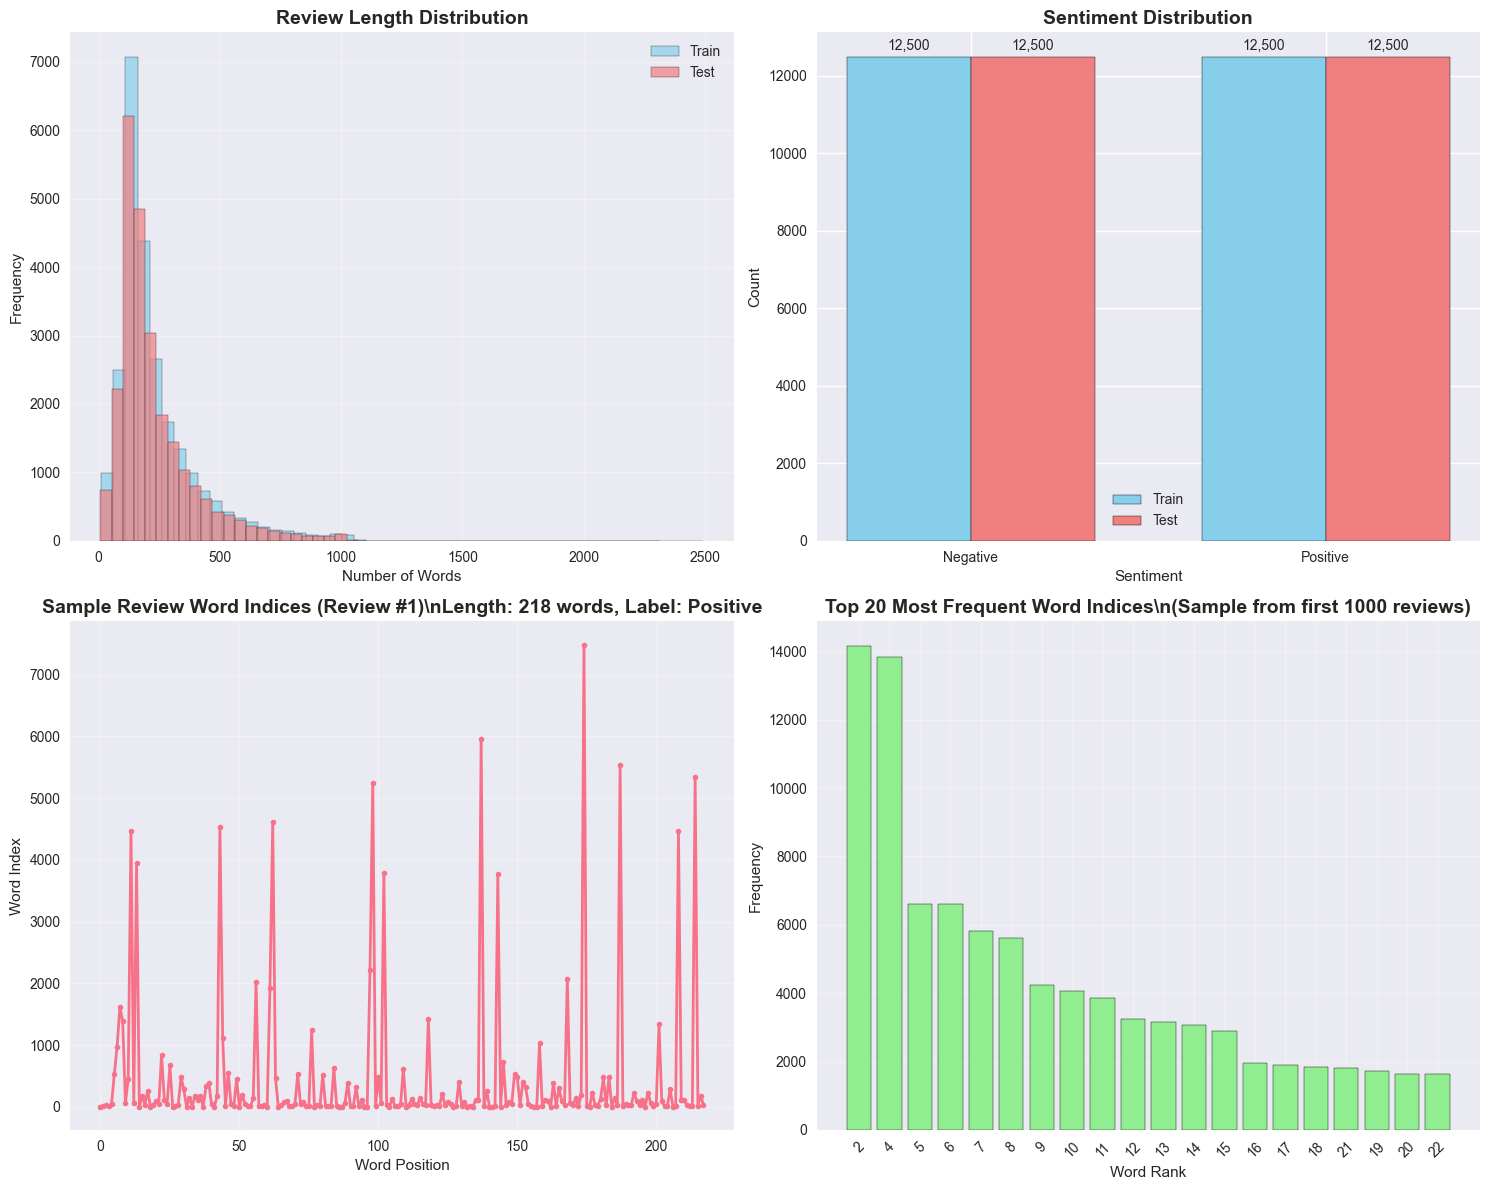

\n🔍 First Training Review Details:
Review indices: [1, 14, 22, 16, 43, 530, 973, 1622, 1385, 65, 458, 4468, 66, 3941, 4, 173, 36, 256, 5, 25, 100, 43, 838, 112, 50, 670, 2, 9, 35, 480, 284, 5, 150, 4, 172, 112, 167, 2, 336, 385, 39, 4, 172, 4536, 1111, 17, 546, 38, 13, 447, 4, 192, 50, 16, 6, 147, 2025, 19, 14, 22, 4, 1920, 4613, 469, 4, 22, 71, 87, 12, 16, 43, 530, 38, 76, 15, 13, 1247, 4, 22, 17, 515, 17, 12, 16, 626, 18, 2, 5, 62, 386, 12, 8, 316, 8, 106, 5, 4, 2223, 5244, 16, 480, 66, 3785, 33, 4, 130, 12, 16, 38, 619, 5, 25, 124, 51, 36, 135, 48, 25, 1415, 33, 6, 22, 12, 215, 28, 77, 52, 5, 14, 407, 16, 82, 2, 8, 4, 107, 117, 5952, 15, 256, 4, 2, 7, 3766, 5, 723, 36, 71, 43, 530, 476, 26, 400, 317, 46, 7, 4, 2, 1029, 13, 104, 88, 4, 381, 15, 297, 98, 32, 2071, 56, 26, 141, 6, 194, 7486, 18, 4, 226, 22, 21, 134, 476, 26, 480, 5, 144, 30, 5535, 18, 51, 36, 28, 224, 92, 25, 104, 4, 226, 65, 16, 38, 1334, 88, 12, 16, 283, 5, 16, 4472, 113, 103, 32, 15, 16, 5345, 19, 178, 32]
Label: 1 

In [3]:
# Visualize dataset characteristics
def plot_dataset_analysis(X_train, X_test, y_train, y_test):
    """Create comprehensive visualizations of the IMDB dataset"""
    
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    
    # 1. Sequence length distribution
    train_lengths = [len(review) for review in X_train]
    test_lengths = [len(review) for review in X_test]
    
    axes[0, 0].hist(train_lengths, bins=50, alpha=0.7, label='Train', color='skyblue', edgecolor='black')
    axes[0, 0].hist(test_lengths, bins=50, alpha=0.7, label='Test', color='lightcoral', edgecolor='black')
    axes[0, 0].set_title('Review Length Distribution', fontsize=14, fontweight='bold')
    axes[0, 0].set_xlabel('Number of Words')
    axes[0, 0].set_ylabel('Frequency')
    axes[0, 0].legend()
    axes[0, 0].grid(True, alpha=0.3)
    
    # 2. Label distribution
    labels = ['Negative', 'Positive']
    train_counts = [len(y_train) - sum(y_train), sum(y_train)]
    test_counts = [len(y_test) - sum(y_test), sum(y_test)]
    
    x = np.arange(len(labels))
    width = 0.35
    
    axes[0, 1].bar(x - width/2, train_counts, width, label='Train', color='skyblue', edgecolor='black')
    axes[0, 1].bar(x + width/2, test_counts, width, label='Test', color='lightcoral', edgecolor='black')
    axes[0, 1].set_title('Sentiment Distribution', fontsize=14, fontweight='bold')
    axes[0, 1].set_xlabel('Sentiment')
    axes[0, 1].set_ylabel('Count')
    axes[0, 1].set_xticks(x)
    axes[0, 1].set_xticklabels(labels)
    axes[0, 1].legend()
    
    # Add value labels on bars
    for i, (train_val, test_val) in enumerate(zip(train_counts, test_counts)):
        axes[0, 1].text(i - width/2, train_val + 100, f'{train_val:,}', ha='center', va='bottom', fontsize=10)
        axes[0, 1].text(i + width/2, test_val + 100, f'{test_val:,}', ha='center', va='bottom', fontsize=10)
    
    # 3. Sample review word indices
    sample_review = X_train[0]
    axes[1, 0].plot(range(len(sample_review)), sample_review, marker='o', markersize=4, linewidth=2)
    axes[1, 0].set_title(f'Sample Review Word Indices (Review #1)\\nLength: {len(sample_review)} words, Label: {"Positive" if y_train[0] else "Negative"}', 
                        fontsize=14, fontweight='bold')
    axes[1, 0].set_xlabel('Word Position')
    axes[1, 0].set_ylabel('Word Index')
    axes[1, 0].grid(True, alpha=0.3)
    
    # 4. Top word indices frequency
    all_words = [word for review in X_train[:1000] for word in review]  # Sample for efficiency
    word_counts = pd.Series(all_words).value_counts().head(20)
    
    axes[1, 1].bar(range(len(word_counts)), word_counts.values, color='lightgreen', edgecolor='black')
    axes[1, 1].set_title('Top 20 Most Frequent Word Indices\\n(Sample from first 1000 reviews)', fontsize=14, fontweight='bold')
    axes[1, 1].set_xlabel('Word Rank')
    axes[1, 1].set_ylabel('Frequency')
    axes[1, 1].set_xticks(range(len(word_counts)))
    axes[1, 1].set_xticklabels([f'{idx}' for idx in word_counts.index], rotation=45)
    axes[1, 1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.savefig('plots/imdb_dataset_analysis.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    return train_lengths, test_lengths

# Generate visualizations
train_lengths, test_lengths = plot_dataset_analysis(X_train, X_test, y_train, y_test)

# Show first review details
print(f"\\n🔍 First Training Review Details:")
print(f"Review indices: {X_train[0]}")
print(f"Label: {y_train[0]} ({'Positive' if y_train[0] else 'Negative'})")
print(f"Length: {len(X_train[0])} words")

In [4]:
# Detailed analysis of sample review
sample_review = X_train[0]   
sample_label = y_train[0]

print("🔍 SAMPLE REVIEW ANALYSIS")
print("="*40)
print(f"Review index: 0")
print(f"Word indices: {sample_review}")
print(f"Number of words: {len(sample_review)}")
print(f"Label: {sample_label} ({'Positive' if sample_label else 'Negative'})")
print(f"Min word index: {min(sample_review)}")
print(f"Max word index: {max(sample_review)}")
print(f"Unique words: {len(set(sample_review))}")

# Show some statistics
print(f"\\n📊 Review Statistics:")
print(f"Mean word index: {np.mean(sample_review):.2f}")
print(f"Median word index: {np.median(sample_review):.2f}")
print(f"Most frequent word index: {max(set(sample_review), key=sample_review.count)}")

sample_review, sample_label

🔍 SAMPLE REVIEW ANALYSIS
Review index: 0
Word indices: [1, 14, 22, 16, 43, 530, 973, 1622, 1385, 65, 458, 4468, 66, 3941, 4, 173, 36, 256, 5, 25, 100, 43, 838, 112, 50, 670, 2, 9, 35, 480, 284, 5, 150, 4, 172, 112, 167, 2, 336, 385, 39, 4, 172, 4536, 1111, 17, 546, 38, 13, 447, 4, 192, 50, 16, 6, 147, 2025, 19, 14, 22, 4, 1920, 4613, 469, 4, 22, 71, 87, 12, 16, 43, 530, 38, 76, 15, 13, 1247, 4, 22, 17, 515, 17, 12, 16, 626, 18, 2, 5, 62, 386, 12, 8, 316, 8, 106, 5, 4, 2223, 5244, 16, 480, 66, 3785, 33, 4, 130, 12, 16, 38, 619, 5, 25, 124, 51, 36, 135, 48, 25, 1415, 33, 6, 22, 12, 215, 28, 77, 52, 5, 14, 407, 16, 82, 2, 8, 4, 107, 117, 5952, 15, 256, 4, 2, 7, 3766, 5, 723, 36, 71, 43, 530, 476, 26, 400, 317, 46, 7, 4, 2, 1029, 13, 104, 88, 4, 381, 15, 297, 98, 32, 2071, 56, 26, 141, 6, 194, 7486, 18, 4, 226, 22, 21, 134, 476, 26, 480, 5, 144, 30, 5535, 18, 51, 36, 28, 224, 92, 25, 104, 4, 226, 65, 16, 38, 1334, 88, 12, 16, 283, 5, 16, 4472, 113, 103, 32, 15, 16, 5345, 19, 178, 32]
Numbe

([1,
  14,
  22,
  16,
  43,
  530,
  973,
  1622,
  1385,
  65,
  458,
  4468,
  66,
  3941,
  4,
  173,
  36,
  256,
  5,
  25,
  100,
  43,
  838,
  112,
  50,
  670,
  2,
  9,
  35,
  480,
  284,
  5,
  150,
  4,
  172,
  112,
  167,
  2,
  336,
  385,
  39,
  4,
  172,
  4536,
  1111,
  17,
  546,
  38,
  13,
  447,
  4,
  192,
  50,
  16,
  6,
  147,
  2025,
  19,
  14,
  22,
  4,
  1920,
  4613,
  469,
  4,
  22,
  71,
  87,
  12,
  16,
  43,
  530,
  38,
  76,
  15,
  13,
  1247,
  4,
  22,
  17,
  515,
  17,
  12,
  16,
  626,
  18,
  2,
  5,
  62,
  386,
  12,
  8,
  316,
  8,
  106,
  5,
  4,
  2223,
  5244,
  16,
  480,
  66,
  3785,
  33,
  4,
  130,
  12,
  16,
  38,
  619,
  5,
  25,
  124,
  51,
  36,
  135,
  48,
  25,
  1415,
  33,
  6,
  22,
  12,
  215,
  28,
  77,
  52,
  5,
  14,
  407,
  16,
  82,
  2,
  8,
  4,
  107,
  117,
  5952,
  15,
  256,
  4,
  2,
  7,
  3766,
  5,
  723,
  36,
  71,
  43,
  530,
  476,
  26,
  400,
  317,
  46,
  7,
  4,
  2,
  1029,
  

In [5]:
# Get word index mapping for text decoding
# This allows us to convert numerical indices back to words
print("Loading IMDB word index mapping...")
word_index = imdb.get_word_index()

print(f"\\n📚 Word Index Information:")
print(f"Total words in vocabulary: {len(word_index):,}")
print(f"Using top {max_features:,} words for our model")

# Show some example word mappings
sample_words = list(word_index.items())[:10]
print(f"\\n🔤 Sample word-to-index mappings:")
for word, idx in sample_words:
    print(f"  '{word}' -> {idx}")

print(f"\\n🔍 Special tokens info:")
print("  Index 0: Padding")
print("  Index 1: Start of sequence") 
print("  Index 2: Unknown word")
print("  Index 3+: Actual vocabulary words")

Loading IMDB word index mapping...
\n📚 Word Index Information:
Total words in vocabulary: 88,584
Using top 10,000 words for our model
\n🔤 Sample word-to-index mappings:
  'fawn' -> 34701
  'tsukino' -> 52006
  'nunnery' -> 52007
  'sonja' -> 16816
  'vani' -> 63951
  'woods' -> 1408
  'spiders' -> 16115
  'hanging' -> 2345
  'woody' -> 2289
  'trawling' -> 52008
\n🔍 Special tokens info:
  Index 0: Padding
  Index 1: Start of sequence
  Index 2: Unknown word
  Index 3+: Actual vocabulary words


In [6]:
word_index

{'fawn': 34701,
 'tsukino': 52006,
 'nunnery': 52007,
 'sonja': 16816,
 'vani': 63951,
 'woods': 1408,
 'spiders': 16115,
 'hanging': 2345,
 'woody': 2289,
 'trawling': 52008,
 "hold's": 52009,
 'comically': 11307,
 'localized': 40830,
 'disobeying': 30568,
 "'royale": 52010,
 "harpo's": 40831,
 'canet': 52011,
 'aileen': 19313,
 'acurately': 52012,
 "diplomat's": 52013,
 'rickman': 25242,
 'arranged': 6746,
 'rumbustious': 52014,
 'familiarness': 52015,
 "spider'": 52016,
 'hahahah': 68804,
 "wood'": 52017,
 'transvestism': 40833,
 "hangin'": 34702,
 'bringing': 2338,
 'seamier': 40834,
 'wooded': 34703,
 'bravora': 52018,
 'grueling': 16817,
 'wooden': 1636,
 'wednesday': 16818,
 "'prix": 52019,
 'altagracia': 34704,
 'circuitry': 52020,
 'crotch': 11585,
 'busybody': 57766,
 "tart'n'tangy": 52021,
 'burgade': 14129,
 'thrace': 52023,
 "tom's": 11038,
 'snuggles': 52025,
 'francesco': 29114,
 'complainers': 52027,
 'templarios': 52125,
 '272': 40835,
 '273': 52028,
 'zaniacs': 52130,

In [7]:
# Create reverse mapping to decode reviews back to text
# This reverses the word_index dictionary for easy lookup
reverse_word_index = {value: key for key, value in word_index.items()}

print("Creating reverse word index mapping...")
print(f"Original word_index maps: word -> index")
print(f"Reverse mapping maps: index -> word")
print(f"\\nTotal mappings created: {len(reverse_word_index):,}")

# Show some example reverse mappings
sample_indices = [1, 2, 3, 4, 5, 10, 20, 50]
print(f"\\n🔢 Sample index-to-word mappings:")
for idx in sample_indices:
    word = reverse_word_index.get(idx, '?')
    print(f"  {idx} -> '{word}'")

print(f"\\n💡 Note: We'll use this to decode numerical reviews back to readable text")

Creating reverse word index mapping...
Original word_index maps: word -> index
Reverse mapping maps: index -> word
\nTotal mappings created: 88,584
\n🔢 Sample index-to-word mappings:
  1 -> 'the'
  2 -> 'and'
  3 -> 'a'
  4 -> 'of'
  5 -> 'to'
  10 -> 'i'
  20 -> 'on'
  50 -> 'more'
\n💡 Note: We'll use this to decode numerical reviews back to readable text


In [8]:
# Decode sample review to readable text
# Subtract 3 from indices because of reserved tokens (0=pad, 1=start, 2=unknown)
def decode_review(encoded_review, reverse_word_index):
    """Decode a review from indices to readable text"""
    return ' '.join([reverse_word_index.get(i - 3, '?') for i in encoded_review])

# Decode the first review
decoded_review = decode_review(sample_review, reverse_word_index)

print("🔤 REVIEW DECODING EXAMPLE")
print("="*50)
print(f"Original indices: {sample_review}")
print(f"Label: {sample_label} ({'Positive' if sample_label else 'Negative'})")
print(f"\\n📖 Decoded review:")
print(f'"{decoded_review}"')

# Analyze the decoded review
words = decoded_review.split()
print(f"\\n📊 Decoded Review Analysis:")
print(f"Word count: {len(words)}")
print(f"Unique words: {len(set(words))}")
print(f"Unknown words ('?'): {words.count('?')}")
print(f"Average word length: {np.mean([len(word) for word in words if word != '?']):.1f} characters")

# Show a few more examples
print(f"\\n🔍 Additional Review Examples:")
for i in range(1, 4):
    decoded = decode_review(X_train[i], reverse_word_index)
    label = "Positive" if y_train[i] else "Negative"
    print(f"\\nReview {i+1} ({label}): {decoded[:100]}...")

decoded_review

🔤 REVIEW DECODING EXAMPLE
Original indices: [1, 14, 22, 16, 43, 530, 973, 1622, 1385, 65, 458, 4468, 66, 3941, 4, 173, 36, 256, 5, 25, 100, 43, 838, 112, 50, 670, 2, 9, 35, 480, 284, 5, 150, 4, 172, 112, 167, 2, 336, 385, 39, 4, 172, 4536, 1111, 17, 546, 38, 13, 447, 4, 192, 50, 16, 6, 147, 2025, 19, 14, 22, 4, 1920, 4613, 469, 4, 22, 71, 87, 12, 16, 43, 530, 38, 76, 15, 13, 1247, 4, 22, 17, 515, 17, 12, 16, 626, 18, 2, 5, 62, 386, 12, 8, 316, 8, 106, 5, 4, 2223, 5244, 16, 480, 66, 3785, 33, 4, 130, 12, 16, 38, 619, 5, 25, 124, 51, 36, 135, 48, 25, 1415, 33, 6, 22, 12, 215, 28, 77, 52, 5, 14, 407, 16, 82, 2, 8, 4, 107, 117, 5952, 15, 256, 4, 2, 7, 3766, 5, 723, 36, 71, 43, 530, 476, 26, 400, 317, 46, 7, 4, 2, 1029, 13, 104, 88, 4, 381, 15, 297, 98, 32, 2071, 56, 26, 141, 6, 194, 7486, 18, 4, 226, 22, 21, 134, 476, 26, 480, 5, 144, 30, 5535, 18, 51, 36, 28, 224, 92, 25, 104, 4, 226, 65, 16, 38, 1334, 88, 12, 16, 283, 5, 16, 4472, 113, 103, 32, 15, 16, 5345, 19, 178, 32]
Label: 1 (Positi

"? this film was just brilliant casting location scenery story direction everyone's really suited the part they played and you could just imagine being there robert ? is an amazing actor and now the same being director ? father came from the same scottish island as myself so i loved the fact there was a real connection with this film the witty remarks throughout the film were great it was just brilliant so much that i bought the film as soon as it was released for ? and would recommend it to everyone to watch and the fly fishing was amazing really cried at the end it was so sad and you know what they say if you cry at a film it must have been good and this definitely was also ? to the two little boy's that played the ? of norman and paul they were just brilliant children are often left out of the ? list i think because the stars that play them all grown up are such a big profile for the whole film but these children are amazing and should be praised for what they have done don't you th

🔧 SEQUENCE PADDING PROCESS
Target sequence length: 500 words
Padding strategy: Truncate longer reviews, pad shorter ones
\n📏 Original Sequence Lengths:
Training - Mean: 238.7, Max: 2494, Min: 11
Test - Mean: 230.8, Max: 2315, Min: 7
\n✂️ Sequence Modifications:
Training - Truncated: 2,108 (8.4%)
Training - Padded: 22,882 (91.5%)
Test - Truncated: 1,925 (7.7%)
Test - Padded: 23,065 (92.3%)
\n🔄 Applying sequence padding...
✅ Padding complete!
New shapes - X_train: (25000, 500), X_test: (25000, 500)
\n🔍 Padding Example (Review 0):
Original length: 218 words
Padded length: 500 words
Original: [1, 14, 22, 16, 43, 530, 973, 1622, 1385, 65, 458, 4468, 66, 3941, 4, 173, 36, 256, 5, 25]... (showing first 20 words)
Padded:   [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]... (showing first 20 words)
Padding added: 282 zeros at the beginning
✅ Padding complete!
New shapes - X_train: (25000, 500), X_test: (25000, 500)
\n🔍 Padding Example (Review 0):
Original length: 218 words
Padded length: 500 words
Or

<Figure size 1200x800 with 0 Axes>

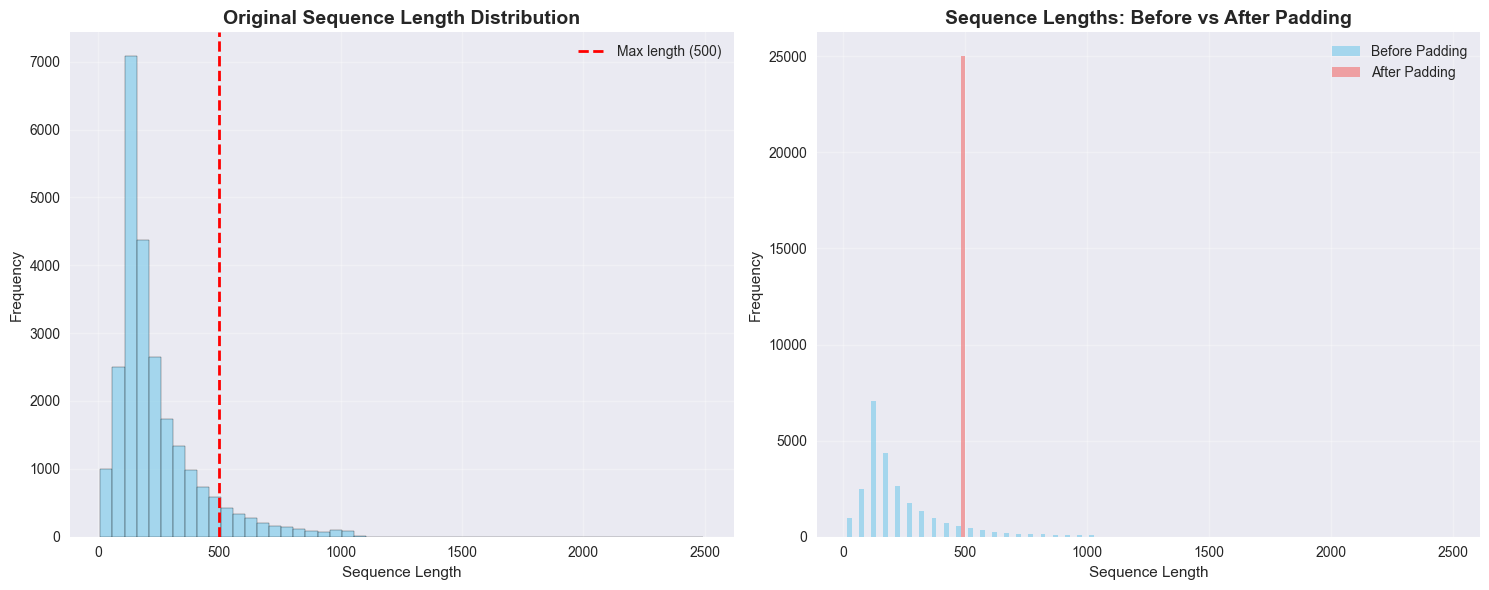

array([[   0,    0,    0, ...,   19,  178,   32],
       [   0,    0,    0, ...,   16,  145,   95],
       [   0,    0,    0, ...,    7,  129,  113],
       ...,
       [   0,    0,    0, ...,    4, 3586,    2],
       [   0,    0,    0, ...,   12,    9,   23],
       [   0,    0,    0, ...,  204,  131,    9]])

In [9]:
# Sequence padding for uniform input length
# RNNs require fixed-length inputs, so we pad/truncate sequences
max_len = 500

print("🔧 SEQUENCE PADDING PROCESS")
print("="*40)
print(f"Target sequence length: {max_len} words")
print(f"Padding strategy: Truncate longer reviews, pad shorter ones")

# Analyze sequence lengths before padding
train_lengths = [len(review) for review in X_train]
test_lengths = [len(review) for review in X_test]

print(f"\\n📏 Original Sequence Lengths:")
print(f"Training - Mean: {np.mean(train_lengths):.1f}, Max: {max(train_lengths)}, Min: {min(train_lengths)}")
print(f"Test - Mean: {np.mean(test_lengths):.1f}, Max: {max(test_lengths)}, Min: {min(test_lengths)}")

# Count sequences that will be truncated vs padded
train_truncated = sum(1 for length in train_lengths if length > max_len)
train_padded = sum(1 for length in train_lengths if length < max_len)
test_truncated = sum(1 for length in test_lengths if length > max_len)
test_padded = sum(1 for length in test_lengths if length < max_len)

print(f"\\n✂️ Sequence Modifications:")
print(f"Training - Truncated: {train_truncated:,} ({train_truncated/len(train_lengths)*100:.1f}%)")
print(f"Training - Padded: {train_padded:,} ({train_padded/len(train_lengths)*100:.1f}%)")
print(f"Test - Truncated: {test_truncated:,} ({test_truncated/len(test_lengths)*100:.1f}%)")
print(f"Test - Padded: {test_padded:,} ({test_padded/len(test_lengths)*100:.1f}%)")

# Apply padding
print("\\n🔄 Applying sequence padding...")
X_train_original = X_train.copy()  # Keep original for comparison
X_test_original = X_test.copy()

X_train = sequence.pad_sequences(X_train, maxlen=max_len)
X_test = sequence.pad_sequences(X_test, maxlen=max_len)

print(f"✅ Padding complete!")
print(f"New shapes - X_train: {X_train.shape}, X_test: {X_test.shape}")

# Show padding example
def show_padding_example(original, padded, index=0):
    """Demonstrate padding effect on a specific review"""
    print(f"\\n🔍 Padding Example (Review {index}):")
    print(f"Original length: {len(original[index])} words")
    print(f"Padded length: {len(padded[index])} words")
    print(f"Original: {original[index][:20]}... (showing first 20 words)")
    print(f"Padded:   {padded[index][:20]}... (showing first 20 words)")
    
    # Show where padding was added (zeros at start for 'pre' padding)
    padding_count = np.sum(padded[index] == 0)
    print(f"Padding added: {padding_count} zeros at the beginning")

show_padding_example(X_train_original, X_train, index=0)

# Create visualization of padding effects
def plot_padding_analysis(original_lengths, max_len):
    """Visualize the effect of padding on sequence lengths"""
    plt.figure(figsize=(12, 8))
    
    # Create subplots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
    
    # Plot 1: Length distribution with max_len line
    ax1.hist(original_lengths, bins=50, alpha=0.7, color='skyblue', edgecolor='black')
    ax1.axvline(max_len, color='red', linestyle='--', linewidth=2, label=f'Max length ({max_len})')
    ax1.set_title('Original Sequence Length Distribution', fontsize=14, fontweight='bold')
    ax1.set_xlabel('Sequence Length')
    ax1.set_ylabel('Frequency')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    # Plot 2: Before/After comparison
    lengths_after = [max_len] * len(original_lengths)  # All sequences now have max_len
    
    ax2.hist([original_lengths, lengths_after], bins=50, alpha=0.7, 
             label=['Before Padding', 'After Padding'], color=['skyblue', 'lightcoral'])
    ax2.set_title('Sequence Lengths: Before vs After Padding', fontsize=14, fontweight='bold')
    ax2.set_xlabel('Sequence Length')
    ax2.set_ylabel('Frequency')
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.savefig('plots/sequence_padding_analysis.png', dpi=300, bbox_inches='tight')
    plt.show()

plot_padding_analysis(train_lengths, max_len)

X_train

In [10]:
# Build Simple RNN Model for Sentiment Classification
print("🏗️ BUILDING SIMPLE RNN MODEL")
print("="*40)

# Model hyperparameters
embedding_dim = 128  # Dimension of word embeddings
rnn_units = 128      # Number of RNN units
dropout_rate = 0.5   # Dropout rate for regularization

print(f"Model Architecture:")
print(f"📚 Vocabulary size: {max_features:,} words")
print(f"🔤 Embedding dimension: {embedding_dim}")
print(f"🧠 RNN units: {rnn_units}")
print(f"📏 Input sequence length: {max_len}")
print(f"🎯 Output: Binary classification (Positive/Negative)")

# Build the model
model = Sequential([
    # Embedding layer: Maps word indices to dense vectors
    Embedding(input_dim=max_features, 
              output_dim=embedding_dim, 
              input_length=max_len,
              name='embedding_layer'),
    
    # Simple RNN layer: Processes sequential information
    SimpleRNN(units=rnn_units, 
              activation='relu',
              dropout=dropout_rate,
              recurrent_dropout=dropout_rate,
              name='simple_rnn_layer'),
    
    # Output layer: Binary classification
    Dense(units=1, 
          activation='sigmoid',
          name='output_layer')
])

print(f"\\n✅ Model architecture created successfully!")
print(f"📊 Total parameters will be calculated after compilation...")

# Calculate expected parameters manually for understanding
embedding_params = max_features * embedding_dim
rnn_params = (embedding_dim + rnn_units + 1) * rnn_units * 3  # Simplified calculation
dense_params = rnn_units + 1

total_estimated = embedding_params + rnn_params + dense_params
print(f"\\n🔢 Estimated Parameters:")
print(f"  Embedding layer: {embedding_params:,}")
print(f"  RNN layer: ~{rnn_params:,}")
print(f"  Dense layer: {dense_params:,}")
print(f"  Total estimated: ~{total_estimated:,}")

model

🏗️ BUILDING SIMPLE RNN MODEL
Model Architecture:
📚 Vocabulary size: 10,000 words
🔤 Embedding dimension: 128
🧠 RNN units: 128
📏 Input sequence length: 500
🎯 Output: Binary classification (Positive/Negative)


\n✅ Model architecture created successfully!
📊 Total parameters will be calculated after compilation...
\n🔢 Estimated Parameters:
  Embedding layer: 1,280,000
  RNN layer: ~98,688
  Dense layer: 129
  Total estimated: ~1,378,817
\n✅ Model architecture created successfully!
📊 Total parameters will be calculated after compilation...
\n🔢 Estimated Parameters:
  Embedding layer: 1,280,000
  RNN layer: ~98,688
  Dense layer: 129
  Total estimated: ~1,378,817


In [11]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_layer (Embedding  (None, 500, 128)          1280000   
 )                                                               
                                                                 
 simple_rnn_layer (SimpleRN  (None, 128)               32896     
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_layer (Embedding  (None, 500, 128)          1280000   
 )                                                               
                                                                 
 simple_rnn_layer (SimpleRN  (None, 128)               32896     
 N)                                                              
                                                                 
 output_layer (Dense)        (None, 1)                 1

In [12]:
# Compile the model with appropriate optimizer, loss, and metrics
print("⚙️ COMPILING THE MODEL")
print("="*30)

# Compilation parameters
optimizer = 'adam'           # Adaptive learning rate optimizer
loss_function = 'binary_crossentropy'  # For binary classification
metrics = ['accuracy', 'precision', 'recall']  # Evaluation metrics

print(f"Configuration:")
print(f"🔧 Optimizer: {optimizer}")
print(f"🎯 Loss function: {loss_function}")
print(f"📊 Metrics: {metrics}")

print(f"\\n💡 Why these choices?")
print(f"• Adam: Adapts learning rate automatically, works well for RNNs")
print(f"• Binary crossentropy: Standard loss for binary classification")
print(f"• Accuracy: Overall correctness percentage")
print(f"• Precision: True positives / (True positives + False positives)")
print(f"• Recall: True positives / (True positives + False negatives)")

# Compile the model
model.compile(
    optimizer=optimizer,
    loss=loss_function,
    metrics=metrics
)

print(f"\\n✅ Model compiled successfully!")
print(f"🚀 Ready for training!")

⚙️ COMPILING THE MODEL
Configuration:
🔧 Optimizer: adam
🎯 Loss function: binary_crossentropy
📊 Metrics: ['accuracy', 'precision', 'recall']
\n💡 Why these choices?
• Adam: Adapts learning rate automatically, works well for RNNs
• Binary crossentropy: Standard loss for binary classification
• Accuracy: Overall correctness percentage
• Precision: True positives / (True positives + False positives)
• Recall: True positives / (True positives + False negatives)


\n✅ Model compiled successfully!
🚀 Ready for training!
\n✅ Model compiled successfully!
🚀 Ready for training!


In [13]:
# Setup training callbacks for better training control
print("🔧 SETTING UP TRAINING CALLBACKS")
print("="*40)

# 1. Early Stopping - Prevents overfitting
early_stopping = EarlyStopping(
    monitor='val_loss',        # Monitor validation loss
    patience=5,                # Wait 5 epochs without improvement
    restore_best_weights=True, # Restore best weights when stopped
    verbose=1,                 # Print when stopping
    mode='min'                 # Minimize validation loss
)

# 2. Model Checkpoint - Save best model during training
model_checkpoint = ModelCheckpoint(
    filepath='models/best_simple_rnn_imdb.h5',
    monitor='val_accuracy',    # Monitor validation accuracy
    save_best_only=True,       # Only save if model improves
    save_weights_only=False,   # Save entire model
    verbose=1,                 # Print when saving
    mode='max'                 # Maximize validation accuracy
)

# 3. Learning Rate Reduction - Reduce LR when learning plateaus
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',        # Monitor validation loss
    factor=0.5,                # Reduce LR by half
    patience=3,                # Wait 3 epochs without improvement
    min_lr=1e-7,              # Minimum learning rate
    verbose=1                  # Print when reducing LR
)

# Combine all callbacks
callbacks = [early_stopping, model_checkpoint, reduce_lr]

print(f"📋 Configured Callbacks:")
print(f"\\n1. 🛑 Early Stopping:")
print(f"   • Monitors: validation loss")
print(f"   • Patience: 5 epochs")
print(f"   • Restores best weights automatically")

print(f"\\n2. 💾 Model Checkpoint:")
print(f"   • Saves to: models/best_simple_rnn_imdb.h5")
print(f"   • Monitors: validation accuracy")
print(f"   • Saves only best performing model")

print(f"\\n3. 📉 Learning Rate Reduction:")
print(f"   • Reduces LR by 50% when validation loss plateaus")
print(f"   • Patience: 3 epochs")
print(f"   • Minimum LR: 1e-7")

print(f"\\n✅ All callbacks configured successfully!")
print(f"🎯 These will help achieve better training results and prevent overfitting")

🔧 SETTING UP TRAINING CALLBACKS
📋 Configured Callbacks:
\n1. 🛑 Early Stopping:
   • Monitors: validation loss
   • Patience: 5 epochs
   • Restores best weights automatically
\n2. 💾 Model Checkpoint:
   • Saves to: models/best_simple_rnn_imdb.h5
   • Monitors: validation accuracy
   • Saves only best performing model
\n3. 📉 Learning Rate Reduction:
   • Reduces LR by 50% when validation loss plateaus
   • Patience: 3 epochs
   • Minimum LR: 1e-7
\n✅ All callbacks configured successfully!
🎯 These will help achieve better training results and prevent overfitting


🚀 STARTING MODEL TRAINING
Training Configuration:
📅 Epochs: 15
📦 Batch size: 32
✂️ Validation split: 20.0% (5,000 samples)
🏋️ Training samples: 20,000
\n⏱️ Training started... This may take several minutes.
📊 Training progress will be displayed below:
\nData verification:
X_train shape: (25000, 500), dtype: int32
y_train shape: (25000,), dtype: int64
X_train min/max: 0/9999
y_train unique values: [0 1]
Epoch 1/15
Epoch 1/15
625/625 [==============================] - ETA: 0s - loss: 730943168.0000 - accuracy: 0.5390 - precision: 0.5328 - recall: 0.6578
Epoch 1: val_accuracy improved from -inf to 0.59320, saving model to models\best_simple_rnn_imdb.h5

Epoch 1: val_accuracy improved from -inf to 0.59320, saving model to models\best_simple_rnn_imdb.h5
625/625 [==============================] - 105s 164ms/step - loss: 730943168.0000 - accuracy: 0.5390 - precision: 0.5328 - recall: 0.6578 - val_loss: 0.6806 - val_accuracy: 0.5932 - val_precision: 0.6099 - val_recall: 0.4889 - lr: 0.0010
Epo

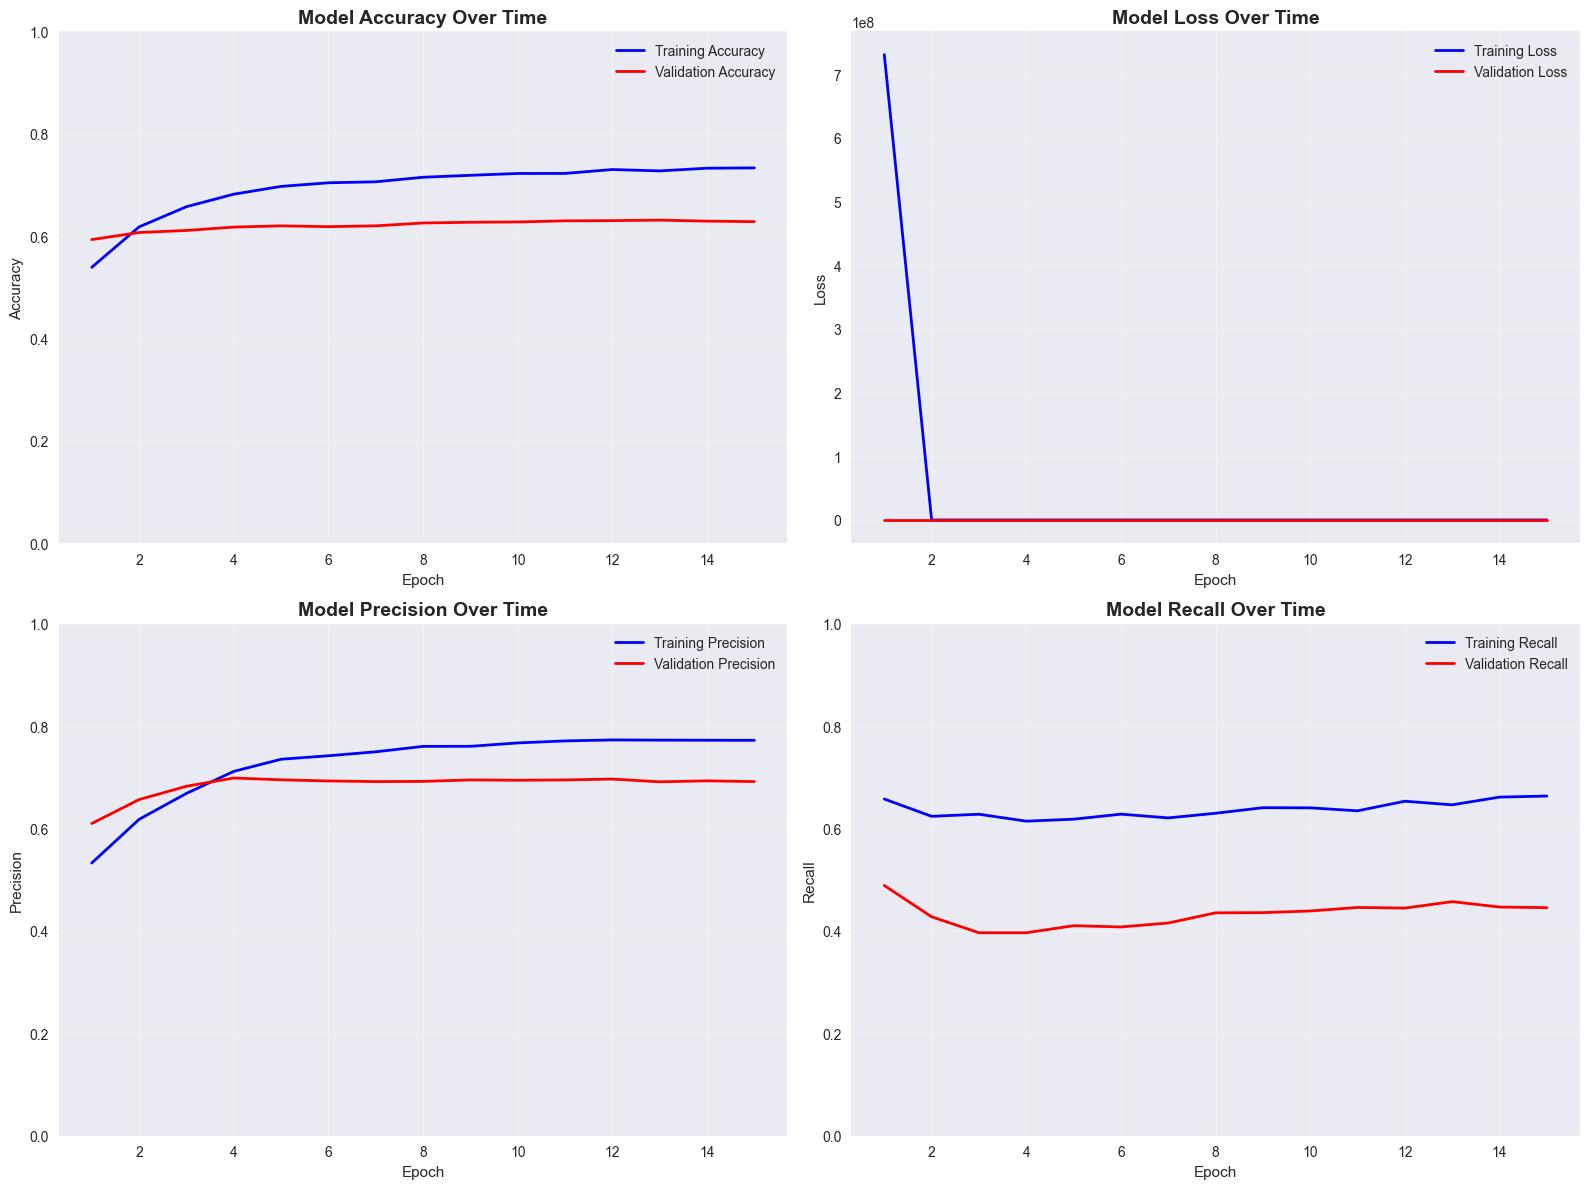

\n💾 Saved files:
• Training plots: plots/training_history.png
• Best model: models/best_simple_rnn_imdb.h5
🎯 Model is ready for evaluation and deployment!


In [16]:
# Train the model with comprehensive monitoring
print("🚀 STARTING MODEL TRAINING")
print("="*40)

# Training parameters
epochs = 15
batch_size = 32
validation_split = 0.2

print(f"Training Configuration:")
print(f"📅 Epochs: {epochs}")
print(f"📦 Batch size: {batch_size}")
print(f"✂️ Validation split: {validation_split*100}% ({int(len(X_train)*validation_split):,} samples)")
print(f"🏋️ Training samples: {int(len(X_train)*(1-validation_split)):,}")

print(f"\\n⏱️ Training started... This may take several minutes.")
print(f"📊 Training progress will be displayed below:")

# Record start time
import time
start_time = time.time()

# Verify data shapes and types
print(f"\\nData verification:")
print(f"X_train shape: {X_train.shape}, dtype: {X_train.dtype}")
print(f"y_train shape: {y_train.shape}, dtype: {y_train.dtype}")
print(f"X_train min/max: {X_train.min()}/{X_train.max()}")
print(f"y_train unique values: {np.unique(y_train)}")

# Ensure proper data types
X_train = X_train.astype('int32')
y_train = y_train.astype('float32')

# Re-compile the model to ensure proper setup
from tensorflow.keras.metrics import Precision, Recall
model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy', Precision(name='precision'), Recall(name='recall')],
    run_eagerly=False
)

# Train the model with error handling
try:
    history = model.fit(
        X_train, y_train,
        epochs=epochs,
        batch_size=batch_size,
        validation_split=validation_split,
        callbacks=callbacks,
        verbose=1,
        shuffle=True
    )
except Exception as e:
    print(f"Training failed with error: {e}")
    print("Trying with run_eagerly=True...")
    
    # Re-compile with eager execution for debugging
    model.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=['accuracy', Precision(name='precision'), Recall(name='recall')],
        run_eagerly=True
    )
    
    history = model.fit(
        X_train, y_train,
        epochs=epochs,
        batch_size=batch_size,
        validation_split=validation_split,
        callbacks=callbacks,
        verbose=1,
        shuffle=True
    )

# Calculate training time
training_time = time.time() - start_time
minutes = int(training_time // 60)
seconds = int(training_time % 60)

print(f"\\n✅ TRAINING COMPLETED!")
print(f"⏱️ Total training time: {minutes}m {seconds}s")
print(f"📈 Training history captured for visualization")

# Extract training metrics for analysis
train_loss = history.history['loss']
val_loss = history.history['val_loss']
train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
train_precision = history.history['precision']
val_precision = history.history['val_precision']
train_recall = history.history['recall']
val_recall = history.history['val_recall']

print(f"\\n📊 Final Training Metrics:")
print(f"Final training accuracy: {train_acc[-1]:.4f}")
print(f"Final validation accuracy: {val_acc[-1]:.4f}")
print(f"Final training loss: {train_loss[-1]:.4f}")
print(f"Final validation loss: {val_loss[-1]:.4f}")
print(f"Best validation accuracy: {max(val_acc):.4f} (Epoch {val_acc.index(max(val_acc))+1})")

# Create comprehensive training visualization
def plot_training_history(history):
    """Create detailed training history plots"""
    
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    epochs_range = range(1, len(history.history['loss']) + 1)
    
    # Plot 1: Accuracy
    axes[0, 0].plot(epochs_range, history.history['accuracy'], 'b-', label='Training Accuracy', linewidth=2)
    axes[0, 0].plot(epochs_range, history.history['val_accuracy'], 'r-', label='Validation Accuracy', linewidth=2)
    axes[0, 0].set_title('Model Accuracy Over Time', fontsize=14, fontweight='bold')
    axes[0, 0].set_xlabel('Epoch')
    axes[0, 0].set_ylabel('Accuracy')
    axes[0, 0].legend()
    axes[0, 0].grid(True, alpha=0.3)
    axes[0, 0].set_ylim([0, 1])
    
    # Plot 2: Loss
    axes[0, 1].plot(epochs_range, history.history['loss'], 'b-', label='Training Loss', linewidth=2)
    axes[0, 1].plot(epochs_range, history.history['val_loss'], 'r-', label='Validation Loss', linewidth=2)
    axes[0, 1].set_title('Model Loss Over Time', fontsize=14, fontweight='bold')
    axes[0, 1].set_xlabel('Epoch')
    axes[0, 1].set_ylabel('Loss')
    axes[0, 1].legend()
    axes[0, 1].grid(True, alpha=0.3)
    
    # Plot 3: Precision
    axes[1, 0].plot(epochs_range, history.history['precision'], 'b-', label='Training Precision', linewidth=2)
    axes[1, 0].plot(epochs_range, history.history['val_precision'], 'r-', label='Validation Precision', linewidth=2)
    axes[1, 0].set_title('Model Precision Over Time', fontsize=14, fontweight='bold')
    axes[1, 0].set_xlabel('Epoch')
    axes[1, 0].set_ylabel('Precision')
    axes[1, 0].legend()
    axes[1, 0].grid(True, alpha=0.3)
    axes[1, 0].set_ylim([0, 1])
    
    # Plot 4: Recall
    axes[1, 1].plot(epochs_range, history.history['recall'], 'b-', label='Training Recall', linewidth=2)
    axes[1, 1].plot(epochs_range, history.history['val_recall'], 'r-', label='Validation Recall', linewidth=2)
    axes[1, 1].set_title('Model Recall Over Time', fontsize=14, fontweight='bold')
    axes[1, 1].set_xlabel('Epoch')
    axes[1, 1].set_ylabel('Recall')
    axes[1, 1].legend()
    axes[1, 1].grid(True, alpha=0.3)
    axes[1, 1].set_ylim([0, 1])
    
    plt.tight_layout()
    plt.savefig('plots/training_history.png', dpi=300, bbox_inches='tight')
    plt.show()

# Generate training visualization
plot_training_history(history)

print(f"\\n💾 Saved files:")
print(f"• Training plots: plots/training_history.png")
print(f"• Best model: models/best_simple_rnn_imdb.h5")
print(f"🎯 Model is ready for evaluation and deployment!")

💾 SAVING MODEL AND FINAL EVALUATION
✅ Final model saved to: models/simple_rnn_imdb.h5
\n📊 EVALUATING MODEL ON TEST SET
Testing on 25,000 samples...
782/782 [==============================] - 32s 40ms/step - loss: 0.6341 - accuracy: 0.6225 - precision: 0.6972 - recall: 0.4332
\n🎯 FINAL TEST RESULTS:
Test Accuracy:  0.6225 (62.25%)
Test Precision: 0.6972
Test Recall:    0.4332
Test Loss:      0.6341
Test F1 Score:  0.5344
\n🔍 GENERATING DETAILED PREDICTIONS...
\n🎯 FINAL TEST RESULTS:
Test Accuracy:  0.6225 (62.25%)
Test Precision: 0.6972
Test Recall:    0.4332
Test Loss:      0.6341
Test F1 Score:  0.5344
\n🔍 GENERATING DETAILED PREDICTIONS...
\n📋 DETAILED CLASSIFICATION REPORT:
              precision    recall  f1-score   support

    Negative       0.59      0.81      0.68     12500
    Positive       0.70      0.43      0.53     12500

    accuracy                           0.62     25000
   macro avg       0.64      0.62      0.61     25000
weighted avg       0.64      0.62      0.6

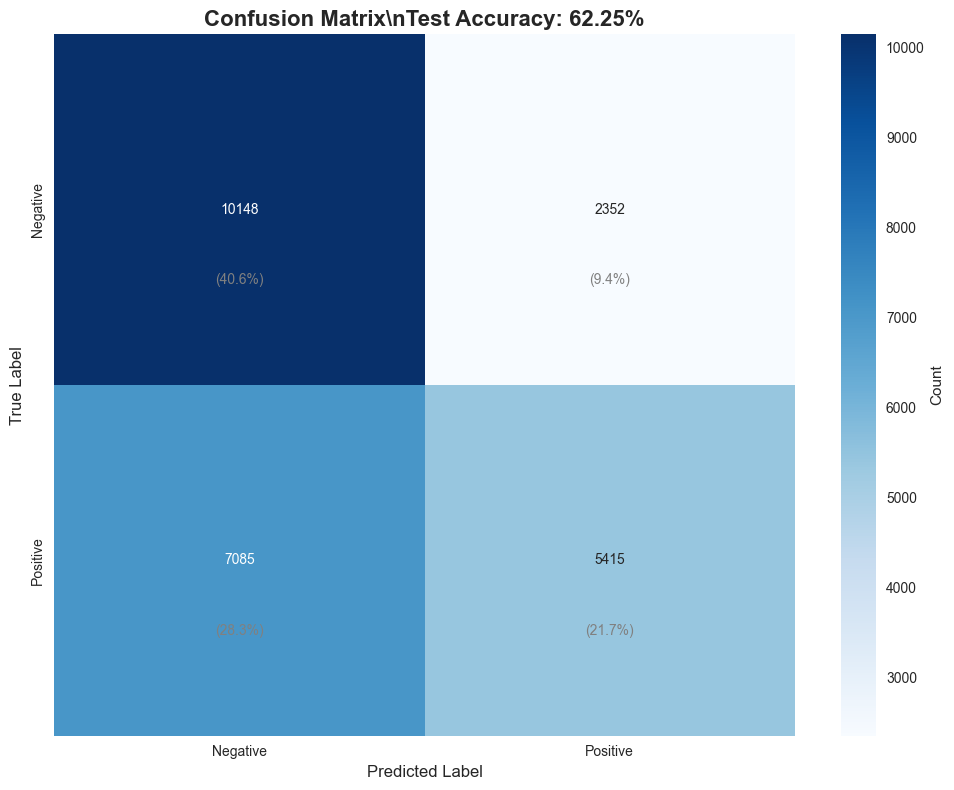

\n🎉 MODEL TRAINING AND EVALUATION COMPLETE!
📁 Generated Files:
  • models/simple_rnn_imdb.h5 (final model)
  • models/best_simple_rnn_imdb.h5 (best model during training)
  • plots/training_history.png
  • plots/confusion_matrix.png
\n🚀 Model is ready for use in predictions and deployment!


In [17]:
# Save final model and evaluate performance
print("💾 SAVING MODEL AND FINAL EVALUATION")
print("="*45)

# Save the final trained model
final_model_path = 'models/simple_rnn_imdb.h5'
model.save(final_model_path)
print(f"✅ Final model saved to: {final_model_path}")

# Evaluate model on test set
print(f"\\n📊 EVALUATING MODEL ON TEST SET")
print(f"Testing on {len(X_test):,} samples...")

test_loss, test_accuracy, test_precision, test_recall = model.evaluate(X_test, y_test, verbose=1)

print(f"\\n🎯 FINAL TEST RESULTS:")
print(f"Test Accuracy:  {test_accuracy:.4f} ({test_accuracy*100:.2f}%)")
print(f"Test Precision: {test_precision:.4f}")
print(f"Test Recall:    {test_recall:.4f}")
print(f"Test Loss:      {test_loss:.4f}")

# Calculate F1 Score
f1_score = 2 * (test_precision * test_recall) / (test_precision + test_recall)
print(f"Test F1 Score:  {f1_score:.4f}")

# Generate predictions for detailed analysis
print(f"\\n🔍 GENERATING DETAILED PREDICTIONS...")
y_pred_prob = model.predict(X_test, verbose=0)
y_pred = (y_pred_prob > 0.5).astype(int).flatten()

# Classification report
from sklearn.metrics import classification_report, confusion_matrix
print(f"\\n📋 DETAILED CLASSIFICATION REPORT:")
print(classification_report(y_test, y_pred, target_names=['Negative', 'Positive']))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
print(f"\\n🔄 CONFUSION MATRIX:")
print(f"                 Predicted")
print(f"               Neg    Pos")
print(f"Actual  Neg   {cm[0,0]:5d}  {cm[0,1]:5d}")
print(f"        Pos   {cm[1,0]:5d}  {cm[1,1]:5d}")

# Calculate additional metrics
tn, fp, fn, tp = cm.ravel()
specificity = tn / (tn + fp)
sensitivity = tp / (tp + fn)

print(f"\\n📈 ADDITIONAL METRICS:")
print(f"True Negatives:  {tn:,}")
print(f"False Positives: {fp:,}")
print(f"False Negatives: {fn:,}")
print(f"True Positives:  {tp:,}")
print(f"Specificity:     {specificity:.4f}")
print(f"Sensitivity:     {sensitivity:.4f}")

# Create confusion matrix visualization
def plot_confusion_matrix(cm, test_accuracy):
    """Create enhanced confusion matrix plot"""
    plt.figure(figsize=(10, 8))
    
    # Create heatmap
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=['Negative', 'Positive'],
                yticklabels=['Negative', 'Positive'],
                cbar_kws={'label': 'Count'})
    
    plt.title(f'Confusion Matrix\\nTest Accuracy: {test_accuracy:.2%}', 
              fontsize=16, fontweight='bold')
    plt.xlabel('Predicted Label', fontsize=12)
    plt.ylabel('True Label', fontsize=12)
    
    # Add percentage annotations
    total = cm.sum()
    for i in range(2):
        for j in range(2):
            percentage = cm[i, j] / total * 100
            plt.text(j+0.5, i+0.7, f'({percentage:.1f}%)', 
                    ha='center', va='center', fontsize=10, color='gray')
    
    plt.tight_layout()
    plt.savefig('plots/confusion_matrix.png', dpi=300, bbox_inches='tight')
    plt.show()

# Generate confusion matrix plot
plot_confusion_matrix(cm, test_accuracy)

print(f"\\n🎉 MODEL TRAINING AND EVALUATION COMPLETE!")
print(f"📁 Generated Files:")
print(f"  • models/simple_rnn_imdb.h5 (final model)")
print(f"  • models/best_simple_rnn_imdb.h5 (best model during training)")
print(f"  • plots/training_history.png")
print(f"  • plots/confusion_matrix.png")
print(f"\\n🚀 Model is ready for use in predictions and deployment!")